In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('kalman.csv', index_col=0)

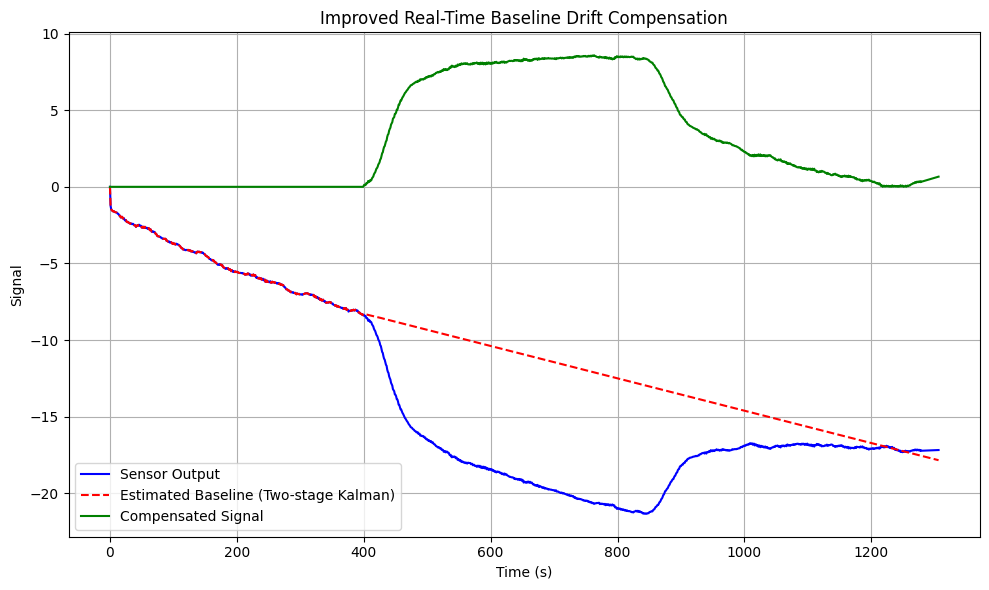

In [ ]:
class RealTimeCorrector:
  def __init__(self, alpha=0.0001, avg_window=None):
    self.alpha = alpha
    self.avg_window = avg_window
    self.baseline = None
    self._buf = []

  def update(self, x):
    if self.avg_window:
      self._buf.append(x)
      if len(self._buf) < self.avg_window:
        return None, None
      if len(self._buf) > self.avg_window:
        self._buf.pop(0)
      x_eff = sum(self._buf) / len(self._buf)
    else:
      x_eff = x

    if self.baseline is None:
      self.baseline = x_eff
    else:
      self.baseline = self.alpha * x_eff + (1 - self.alpha) * self.baseline

    return self.baseline, (x_eff - self.baseline)

def linear_estimation(data, initial_segment_length, window_size):
  slopes, intercepts = [], []
  for i in range(initial_segment_length - window_size):
    i_var = np.arange(i,i+window_size)
    y_var = data[i:i+window_size]
    numerator = window_size * np.sum(i_var * y_var) - np.sum(i_var) * np.sum(y_var)
    denominator = window_size * np.sum(np.square(i_var)) - np.square(np.sum(i_var))
    a_t = numerator/denominator
    b_t = (1/window_size) * np.sum(y_var) - (a_t/window_size) * np.sum(i_var)
    slopes.append(a_t)
    intercepts.append(b_t)
  return slopes, intercepts

def kalman_filter(x, P, z, Q=1e-5, R=0.001):
    x_pred = x
    for i in range(len(z)):
      P_pred = P + Q
      K = P_pred / (P_pred + R)
      x_updated = x_pred + K * (z[i] - x_pred)
      P_updated = (1 - K) * P_pred
      x_pred = x_updated
      P = P_updated
    return x_updated, P_updated

def coefficient(temperature, window_size, idx):
  left = 1 + abs(temperature[idx] - temperature[idx - 1])
  numerator = 0
  denominator = window_size
  for i in range(idx - window_size - 1, idx - 2):
    numerator += abs(temperature[i] - temperature[i + 1])
  res = left - (numerator/denominator)
  return res

def update_slope_intercept(temperature, window_size, idx, slope_intercept, prev_slope_intercept):
  left_numerator = abs(temperature[idx] - temperature[idx - 1])
  right_numerator = 0
  denominator = 0
  for i in range(idx - window_size, idx - 1):
    right_numerator += abs(temperature[i] - temperature[i + 1])

  for i in range(idx - window_size - 1, idx - 2):
    denominator += abs(temperature[i] - temperature[i + 1])

  res = slope_intercept * (left_numerator/denominator) + prev_slope_intercept * (right_numerator/denominator)
  return res

def baseline_estimation(intercepts, slopes, initial_segment_length, dc0, window_size):
  P_slope, P_intercept = 1.0, 1.0
  baseline_prediction = []
  for i in range(initial_segment_length, len(dc0)):
    slope, P_slope = kalman_filter(slopes[-window_size], P_slope, slopes[-window_size + 1:])
    intercept, P_intercept = kalman_filter(intercepts[-window_size], P_intercept, intercepts[-window_size + 1:])

    # coef = coefficient(temperature, window_size, i)
    # slope_coef = slope * coef
    # intercept_coef = intercept * coef
    # baseline = (slope_coef * i) + intercept_coef
    # baseline_prediction.append(baseline)
    baseline = slope * i + intercept
    baseline_prediction.append(baseline)

    if i == initial_segment_length:
      prev_slope = 0
      prev_intercept = 0
    # slope = update_slope_intercept(temperature, window_size, i, slope, prev_slope)
    # intercept = update_slope_intercept(temperature, window_size, i, intercept, prev_intercept)

    prev_slope = slope
    prev_intercept = intercept
    slopes.append(slope)
    intercepts.append(intercept)
  return baseline_prediction

def plot_estimation(dc0, baseline_full, compensated_signal):
  plt.figure(figsize=(10, 6))
  plt.plot(np.arange(df.shape[0]), dc0, label='Sensor Output', color='blue')
  plt.plot(np.arange(df.shape[0]), baseline_full, label='Estimated Baseline (Two-stage Kalman)', color='red', linestyle='--')
  plt.plot(np.arange(df.shape[0]), compensated_signal, label='Compensated Signal', color='green')
  plt.xlabel('Time (s)')
  plt.ylabel('Signal')
  plt.title('Improved Real-Time Baseline Drift Compensation')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

# initialization
corrector = RealTimeCorrector()
window_size = 30
initial_segment_length = 400
dc0 = [corrector.update(i)[1] for i in df['0']]

# 1st step
slopes, intercepts = linear_estimation(dc0, initial_segment_length, window_size)

# 2nd step
baseline_prediction = baseline_estimation(intercepts, slopes, initial_segment_length, dc0, window_size)

# compensated signal
baseline_full = np.concatenate([dc0[:initial_segment_length], baseline_prediction])
compensated_signal = dc0 - baseline_full
for i in range(len(compensated_signal)):
  if compensated_signal[i] < 0:
    compensated_signal[i] = abs(compensated_signal[i])

# MSE
# baseline_to_dc0 = mean_squared_error(baseline_full, dc0)
# compensated_to_dc0 = mean_squared_error(compensated_signal, dc0)
# print(f'''Initial Segment Length: {initial_segment_length}\n
# Window Size: {window_size}\n
# Estimating Baseline for {len(dc0) - initial_segment_length} values\n
# Baseline to dc0 MSE: {round(baseline_to_dc0, 4)}\n
# Compensated to dc0 MSE: {round(compensated_to_dc0, 4)}''')

# plot
plot_estimation(dc0, baseline_full, compensated_signal)